# 深度循环神经网络

:label:`sec_deep_rnn`

到目前为止，我们只讨论了具有一个单向隐藏层的循环神经网络。
其中，隐变量和观测值与具体的函数形式的交互方式是相当随意的。
只要交互类型建模具有足够的灵活性，这就不是一个大问题。
然而，对一个单层来说，这可能具有相当的挑战性。
之前在线性模型中，我们通过添加更多的层来解决这个问题。
而在循环神经网络中，我们首先需要确定如何添加更多的层，
以及在哪里添加额外的非线性，因此这个问题有点棘手。

事实上，我们可以将多层循环神经网络堆叠在一起，
通过对几个简单层的组合，产生了一个灵活的机制。
特别是，数据可能与不同层的堆叠有关。
例如，我们可能希望保持有关金融市场状况
（熊市或牛市）的宏观数据可用，
而微观数据只记录较短期的时间动态。

 :numref:`fig_deep_rnn`描述了一个具有$L$个隐藏层的深度循环神经网络，
每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。

![深度循环神经网络结构](../img/deep-rnn.svg)
:label:`fig_deep_rnn`

## 函数依赖关系

我们可以将深度架构中的函数依赖关系形式化，
这个架构是由 :numref:`fig_deep_rnn`中描述了$L$个隐藏层构成。
后续的讨论主要集中在经典的循环神经网络模型上，
但是这些讨论也适应于其他序列模型。

假设在时间步$t$有一个小批量的输入数据
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$
（样本数：$n$，每个样本中的输入数：$d$）。
同时，将$l^\mathrm{th}$隐藏层（$l=1,\ldots,L$）
的隐状态设为$\mathbf{H}_t^{(l)}  \in \mathbb{R}^{n \times h}$
（隐藏单元数：$h$），
输出层变量设为$\mathbf{O}_t \in \mathbb{R}^{n \times q}$
（输出数：$q$）。
设置$\mathbf{H}_t^{(0)} = \mathbf{X}_t$，
第$l$个隐藏层的隐状态使用激活函数$\phi_l$，则：

$$\mathbf{H}_t^{(l)} = \phi_l(\mathbf{H}_t^{(l-1)} \mathbf{W}_{xh}^{(l)} + \mathbf{H}_{t-1}^{(l)} \mathbf{W}_{hh}^{(l)}  + \mathbf{b}_h^{(l)}),$$
:eqlabel:`eq_deep_rnn_H`

其中，权重$\mathbf{W}_{xh}^{(l)} \in \mathbb{R}^{h \times h}$，
$\mathbf{W}_{hh}^{(l)} \in \mathbb{R}^{h \times h}$和
偏置$\mathbf{b}_h^{(l)} \in \mathbb{R}^{1 \times h}$
都是第$l$个隐藏层的模型参数。

最后，输出层的计算仅基于第$l$个隐藏层最终的隐状态：

$$\mathbf{O}_t = \mathbf{H}_t^{(L)} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$都是输出层的模型参数。

与多层感知机一样，隐藏层数目$L$和隐藏单元数目$h$都是超参数。
也就是说，它们可以由我们调整的。
另外，用门控循环单元或长短期记忆网络的隐状态
来代替 :eqref:`eq_deep_rnn_H`中的隐状态进行计算，
可以很容易地得到深度门控循环神经网络或深度长短期记忆神经网络。

## 简洁实现

实现多层循环神经网络所需的许多逻辑细节在高级API中都是现成的。
简单起见，我们仅示范使用此类内置函数的实现方式。
以长短期记忆网络模型为例，
该代码与之前在 :numref:`sec_lstm`中使用的代码非常相似，
实际上唯一的区别是我们指定了层的数量，
而不是使用单一层这个默认值。
像往常一样，我们从加载数据集开始。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

像选择超参数这类架构决策也跟 :numref:`sec_lstm`中的决策非常相似。
因为我们有不同的词元，所以输入和输出都选择相同数量，即`vocab_size`。
隐藏单元的数量仍然是$256$。
唯一的区别是，我们现在(**通过`num_layers`的值来设定隐藏层数**)。


In [2]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

## [**训练**]与预测

由于使用了长短期记忆网络模型来实例化两个层，因此训练速度被大大降低了。


perplexity 1.0, 224250.2 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


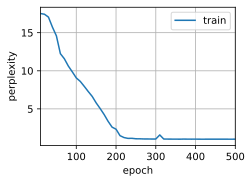

In [3]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)

## 小结

* 在深度循环神经网络中，隐状态的信息被传递到当前层的下一时间步和下一层的当前时间步。
* 有许多不同风格的深度循环神经网络，
  如长短期记忆网络、门控循环单元、或经典循环神经网络。
  这些模型在深度学习框架的高级API中都有涵盖。
* 总体而言，深度循环神经网络需要大量的调参（如学习率和修剪）
  来确保合适的收敛，模型的初始化也需要谨慎。

## 练习

1. 基于我们在 :numref:`sec_rnn_scratch`中讨论的单层实现，
   尝试从零开始实现两层循环神经网络。
1. 在本节训练模型中，比较使用门控循环单元替换长短期记忆网络后模型的精确度和训练速度。
1. 如果增加训练数据，能够将困惑度降到多低？
1. 在为文本建模时，是否可以将不同作者的源数据合并？有何优劣呢？


[Discussions](https://discuss.d2l.ai/t/2770)
